In [3]:
correction_list = {
    "Kim K": "Kim K.",
    "Al Ghareeb M.": "Al-Ghareeb M.",
    "Al Khulaifi N.G.": "Al-Khulaifi N.G.",
    "Alawadhi O.": "Al-Awadhi O.",
    "Bahrouzyan O.": "Al-Awadhi O.",
    "Haji A.": "Al-Haji A.",
    "Hajji A.": "Al-Haji A.",
    "El Aarej M.": "El-Aarej M.",
    "El Amrani R.": "El-Amrani R.",
    "El Aynaoui Y.": "El-Aynaoui Y.",
    "Granollers Pujol G.": "Granollers-Pujol G.",
    "Granollers G.": "Granollers-Pujol G.",
    "Granollers M.": "Granollers-Pujol M.",
    "Al Mutawa J.": "Ali Mutawa J.M.",
    "Al-Mutawa J.": "Ali Mutawa J.M.",
    "Bogomolov Jr. A.": "Bogomolov Jr.A.",
    "Bogomolov A.": "Bogomolov Jr.A.",
    "Carreno Busta": "Carreno-Busta",
    "Chela J.": "Chela J.I.",
    "Dutra Silva R.": "Dutra da Silva R.",
    "Dutra Da Silva R.": "Dutra da Silva R.",
    "Ferrero J.": "Ferrero J.C.",
    "Gambill J. M.": "Gambill J.M.",
    "Guzman J.": "Guzman J.P.",
    "Haider-Mauer A.": "Haider-Maurer A.",
    "Zayid M. S.": "Zayid M.S.",
    "De Bakker T.": "de Bakker T.",
    "De Chaunac S.": "de Chaunac S.",
    "De Greef A.": "de Greef A.",
    "De Heart R.": "de Heart R.",
    "De Loore J.": "de Loore J.",
    "De Minaur A.": "de Minaur A.",
    "De Schepper K.": "de Schepper K.",
    "De Voest R.": "de Voest R.",
    "Del Bonis F.": "del Bonis F.",
    "Del Potro J.": "del Potro J.M.",
    "Del Potro J. M.": "del Potro J.M.",
    "Del Potro J.M.": "del Potro J.M.",
    "Van D. Merwe I.": "van D. Merwe I.",
    "Van Der Merwe I.": "van Der Merwe I.",
    "Van Lottum J.": "van Lottum J.",
    "Van Rijthoven T.": "van Rijthoven T.",
    "Van der Dium A.": "van der Dium A.",
    "Van der Merwe I.": "van der Merwe I.",
    "Munoz De La Nava D.": "Munoz de la Nava D.",
    "Munoz de La Nava D.": "Munoz de la Nava D.",
    "Munoz-De La Nava D.": "Munoz de la Nava D.",
    "Di Mauro A.": "di Mauro A.",
    "Di Pasquale A.": "di Pasquale A.",
}

drop_list = ["W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5", "Wsets", "Lsets", "CBW", "CBL", "GBW", "GBL", "IWW", "IWL", "SBW", "SBL", "B&WW", "B&WL", "EXW", "EXL", "UBW", "UBL", "LBW", "LBL", "SJW", "SJL", "MaxW", "MaxL", "AvgW", "AvgL", "WRank", "LRank"]

Let's download, save, cleanup, and agregate the data into a dataframe and and save it to a csv file. We also caculate the elo rate of each player right before the game as well as the probability for the winner to win the game based on the elo rates of the two players.

In [4]:
import pandas as pd
import numpy as np
import requests
import io
import datetime

# Download the data
url_base = "http://tennis-data.co.uk/"

sess = requests.session()
df_list = []
for year in range(2000, 2013):
    url = f"{url_base}/{year}/{year}.xls"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xls", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))

for year in range(2013, datetime.datetime.now().year+1):
    url = f"{url_base}/{year}/{year}.xlsx"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xlsx", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))
sess.close()

# Put the downloaded data together
df_atp = pd.concat(df_list, axis=0).drop(labels=drop_list, axis=1) 

# Cleanup the data
df_atp["Winner"] = df_atp["Winner"].str.strip()
df_atp["Loser"] = df_atp["Loser"].str.strip()

df_atp["Winner"] = df_atp["Winner"].replace(correction_list)
df_atp["Loser"] = df_atp["Loser"].replace(correction_list)

df_atp["Best of"] = pd.to_numeric(df_atp["Best of"], errors="coerce", downcast="integer")
df_atp["WPts"] = pd.to_numeric(df_atp["WPts"], errors="coerce", downcast="integer")
df_atp["LPts"] = pd.to_numeric(df_atp["LPts"], errors="coerce", downcast="integer")

df_atp["Date"] = pd.to_datetime(df_atp["Date"])

# Calculate the elo rate and number of played matches for each player at the begining of the match.
# Also calculate the probability for the winner of the game to win the game based on the elo rates
elo_start = 1500.0
k_factor = 32.0

df_atp[["match_count_winner", "match_count_loser"]] = 0
df_atp[["elo_winner", "elo_loser"]] = elo_start
df_atp["proba_elo"] = .5

df_atp = df_atp.sort_values(by=["ATP", "Date"]).reset_index(drop=True).copy()

elo_rates = pd.DataFrame(data={"Player": pd.concat([df_atp["Winner"], df_atp["Loser"]], axis=0).unique(), "pts": 0, "match_count":  0, "elo": elo_start})
for index, _ in df_atp.iterrows():
    # Set atp points
    wpts = df_atp.loc[index, "WPts"]
    if np.isnan(wpts):
        df_atp.loc[index, "WPts"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "pts"].values[0]
    else:
        elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "pts"] = wpts
    
    lpts = df_atp.loc[index, "LPts"]
    if np.isnan(lpts):
        df_atp.loc[index, "LPts"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "pts"].values[0]
    else:
        elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "pts"] = lpts

    # Set the current elo rate/match count for the winner and loser of the match
    df_atp.loc[index, "elo_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"].values[0]
    df_atp.loc[index, "elo_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"].values[0]
    df_atp.loc[index, "match_count_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "match_count"].values[0]
    df_atp.loc[index, "match_count_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "match_count"].values[0]

    # Set the probability of the outcome based on the elo rates
    df_atp.loc[index, "proba_elo"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, "elo_loser"] - df_atp.loc[index, "elo_winner"])))

    # Update the elo scores/match counts based on the outcome of the match
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"] += k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"] -= k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "match_count"] += 1
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "match_count"] += 1

# Save the result in respective files
df_atp.to_csv("archive/atp_data.csv")
elo_rates.to_csv("archive/elo_rates.csv")

Here, I add more features to the dataset, namely, match count and elo rates with respect to the specific court and surface type in which the game is played.

In [5]:
import pandas as pd
import numpy as np

# Load data from the disk
df_atp = pd.read_csv("archive/atp_data.csv", index_col=0)
elo_rates = pd.read_csv("archive/elo_rates.csv", index_col=0)

court_surface_type = df_atp[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()

try:
    elo_start
except NameError:
    elo_start = 1500.0
    k_factor = 32.0

# Initialize new columns in datasets
for pair in court_surface_type:
    col_name = f"{pair[0].lower()}_{pair[1].lower()}"
    df_atp[[f"match_count_{col_name}_winner", f"match_count_{col_name}_loser"]] = 0
    df_atp[[f"elo_{col_name}_winner", f"elo_{col_name}_loser"]] = elo_start
    df_atp[f"proba_elo_{col_name}"] = .5
    

    elo_rates[f"match_count_{col_name}"] = 0
    elo_rates[f"elo_{col_name}"] = elo_start

# Add the field specific elo rates and played match count of the players
for index, _ in df_atp.iterrows():
    field_type = f"{df_atp.loc[index, 'Court'].lower()}_{df_atp.loc[index, 'Surface'].lower()}"
    for pair in court_surface_type:
        col_name = f"{pair[0].lower()}_{pair[1].lower()}"

        # Set the current match count for the winner and loser of the match (court/surface specific)
        df_atp.loc[index, f"match_count_{col_name}_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"match_count_{col_name}"].values[0]
        df_atp.loc[index, f"match_count_{col_name}_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"match_count_{col_name}"].values[0]

        # Set the current elo rate of the winner and loser of the match (court/surface specific)
        df_atp.loc[index, f"elo_{col_name}_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"elo_{col_name}"].values[0]
        df_atp.loc[index, f"elo_{col_name}_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"elo_{col_name}"].values[0]
        
        # Set the probability of the outcome based on the elo rates (court/surface specific)
        df_atp.loc[index, f"proba_elo_{col_name}"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, f"elo_{col_name}_loser"] - df_atp.loc[index, f"elo_{col_name}_winner"])))
    
    # Update match counts based on the outcome of the match (court/surface specific)
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"match_count_{field_type}"] += 1
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"match_count_{field_type}"] += 1

    # Update elo rates based on the outcome of the match (court/surface specific)
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], f"elo_{field_type}"] += k_factor*(1.0 - df_atp.loc[index, f"proba_elo_{field_type}"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], f"elo_{field_type}"] -= k_factor*(1.0 - df_atp.loc[index, f"proba_elo_{field_type}"])

# Save the new dataset (enriched dataset)
df_atp.to_csv("archive/atp_data_enriched.csv")
elo_rates.to_csv("archive/elo_rates_enriched.csv")

# Show its info
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64516 entries, 0 to 64515
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ATP                               64516 non-null  int64  
 1   Location                          64516 non-null  object 
 2   Tournament                        64516 non-null  object 
 3   Date                              64516 non-null  object 
 4   Series                            64516 non-null  object 
 5   Court                             64516 non-null  object 
 6   Surface                           64516 non-null  object 
 7   Round                             64516 non-null  object 
 8   Best of                           64501 non-null  float64
 9   Winner                            64516 non-null  object 
 10  Loser                             64516 non-null  object 
 11  Comment                           64516 non-null  object 
 12  B365W    

In [6]:
elo_rates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1626 entries, 0 to 1625
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Player                     1626 non-null   object 
 1   pts                        1626 non-null   int64  
 2   match_count                1626 non-null   int64  
 3   elo                        1626 non-null   float64
 4   match_count_indoor_hard    1626 non-null   int64  
 5   elo_indoor_hard            1626 non-null   float64
 6   match_count_indoor_carpet  1626 non-null   int64  
 7   elo_indoor_carpet          1626 non-null   float64
 8   match_count_indoor_clay    1626 non-null   int64  
 9   elo_indoor_clay            1626 non-null   float64
 10  match_count_outdoor_hard   1626 non-null   int64  
 11  elo_outdoor_hard           1626 non-null   float64
 12  match_count_outdoor_clay   1626 non-null   int64  
 13  elo_outdoor_clay           1626 non-null   float64
 1

One can read all datasets directly from the disk and avoid doing the time consuming processing

In [1]:
import pandas as pd

# Load data from the disk
elo_rates = pd.read_csv("archive/elo_rates_enriched.csv", index_col=0)
df_atp = pd.read_csv("archive/atp_data_enriched.csv", index_col=0)
# df_conf = pd.read_csv("archive/confidence_data.csv")

df_atp["Date"] = pd.to_datetime(df_atp["Date"])

# Drop 350 rows where bet odds are absent
# We just ignore the odds for losers cause they do not appear in our futher analysis.
df_atp_reduced = df_atp.dropna(subset=["PSW", "B365W"], axis=0)

# Save dataframes on the disk
df_atp_reduced.to_csv("archive/df_atp_reduced.csv")

# Display the first few rows to verify the changes
df_atp_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49074 entries, 125 to 64485
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ATP                               49074 non-null  int64         
 1   Location                          49074 non-null  object        
 2   Tournament                        49074 non-null  object        
 3   Date                              49074 non-null  datetime64[ns]
 4   Series                            49074 non-null  object        
 5   Court                             49074 non-null  object        
 6   Surface                           49074 non-null  object        
 7   Round                             49074 non-null  object        
 8   Best of                           49059 non-null  float64       
 9   Winner                            49074 non-null  object        
 10  Loser                             49074 non-null 

In [2]:
df_atp_reduced.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,match_count_outdoor_clay_winner,match_count_outdoor_clay_loser,elo_outdoor_clay_winner,elo_outdoor_clay_loser,proba_elo_outdoor_clay,match_count_outdoor_grass_winner,match_count_outdoor_grass_loser,elo_outdoor_grass_winner,elo_outdoor_grass_loser,proba_elo_outdoor_grass
64481,68,Turin,Masters Cup,2022-11-18,Masters Cup,Indoor,Hard,Round Robin,NaN,Djokovic N.,...,327,54,1945.543435,1548.703881,0.907576,128,60,2031.642431,1669.640108,0.889324
64482,68,Turin,Masters Cup,2022-11-18,Masters Cup,Indoor,Hard,Round Robin,NaN,Rublev A.,...,100,123,1690.520786,1806.636908,0.338851,27,35,1625.000143,1597.077705,0.540097
64483,68,Turin,Masters Cup,2022-11-19,Masters Cup,Indoor,Hard,Semifinals,NaN,Djokovic N.,...,327,64,1945.543435,1568.251261,0.897695,128,44,2031.642431,1571.271783,0.934018
64484,68,Turin,Masters Cup,2022-11-19,Masters Cup,Indoor,Hard,Semifinals,NaN,Ruud C.,...,175,100,1768.907144,1690.520786,0.610931,12,27,1454.898202,1625.000143,0.273053
64485,68,Turin,Masters Cup,2022-11-20,Masters Cup,Indoor,Hard,The Final,NaN,Djokovic N.,...,327,175,1945.543435,1768.907144,0.734349,128,12,2031.642431,1454.898202,0.965109


# Get a sense of the bet odds:

In [3]:
df_atp_reduced[["PSW", "PSL", "B365W", "B365L"]].describe()

,PSW,PSL,B365W,B365L
count,49074.000000,49074.000000,49074.000000,49074.000000
mean,1.926528,4.021260,1.836080,3.518870
std,1.281506,5.091518,1.124247,3.491994
min,0.972000,1.010000,0.971000,0.967000
25%,1.280000,1.781000,1.250000,1.720000
50%,1.560000,2.610000,1.500000,2.500000
75%,2.150000,4.120000,2.100000,3.750000
max,46.000000,121.000000,34.000000,101.000000


In [4]:
elo_rates.describe()

,pts,match_count,elo,match_count_indoor_hard,elo_indoor_hard,match_count_indoor_carpet,elo_indoor_carpet,match_count_indoor_clay,elo_indoor_clay,match_count_outdoor_hard,elo_outdoor_hard,match_count_outdoor_clay,elo_outdoor_clay,match_count_outdoor_grass,elo_outdoor_grass
count,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000
mean,360.161747,79.355474,1500.000000,11.856089,1500.000000,2.083641,1500.000000,0.398524,1500.000000,31.239852,1500.000000,25.028290,1500.000000,8.749077,1500.000000
std,614.830593,162.745004,85.423172,27.523085,49.943204,7.029810,21.621552,1.835003,8.526743,67.841038,71.774596,55.586765,64.697092,19.078713,50.862880
min,0.000000,1.000000,1317.878941,0.000000,1361.638420,0.000000,1397.458084,0.000000,1416.600077,0.000000,1269.087230,0.000000,1335.168210,0.000000,1335.573562
25%,6.250000,2.000000,1461.147811,0.000000,1484.000000,0.000000,1500.000000,0.000000,1500.000000,0.000000,1471.745131,0.000000,1477.234823,0.000000,1484.000000
50%,165.000000,8.000000,1483.127317,1.000000,1500.000000,0.000000,1500.000000,0.000000,1500.000000,2.000000,1500.000000,2.000000,1500.000000,1.000000,1500.000000
75%,442.750000,74.750000,1505.433664,8.000000,1500.000000,0.000000,1500.000000,0.000000,1500.000000,25.000000,1500.000000,21.750000,1500.000000,8.000000,1500.000000
max,6730.000000,1442.000000,2023.491115,251.000000,1945.849970,69.000000,1743.530935,22.000000,1625.072438,638.000000,2150.327076,500.000000,2114.613427,213.000000,2031.642431


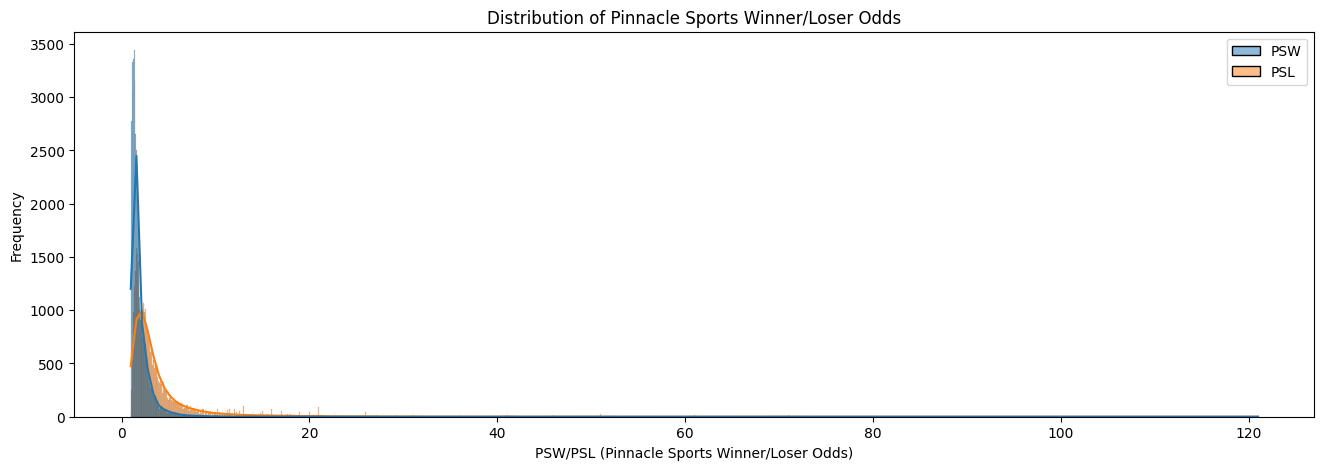

They max on 46.0 (for winners) and 121.0 (for losers).


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
plt.grid()
sns.histplot(df_atp_reduced[["PSW", "PSL"]], kde=True, color=[["green"], ["red"]])

# Add labels and title
plt.title('Distribution of Pinnacle Sports Winner/Loser Odds')
plt.xlabel('PSW/PSL (Pinnacle Sports Winner/Loser Odds)')
plt.ylabel('Frequency')

# Save the plot
plt.savefig('report/final/pictures/ps-odds-dist.pdf')

# Show the plot
plt.show()
print(f"They max on {df_atp_reduced['PSW'].max()} (for winners) and {df_atp_reduced['PSL'].max()} (for losers).")

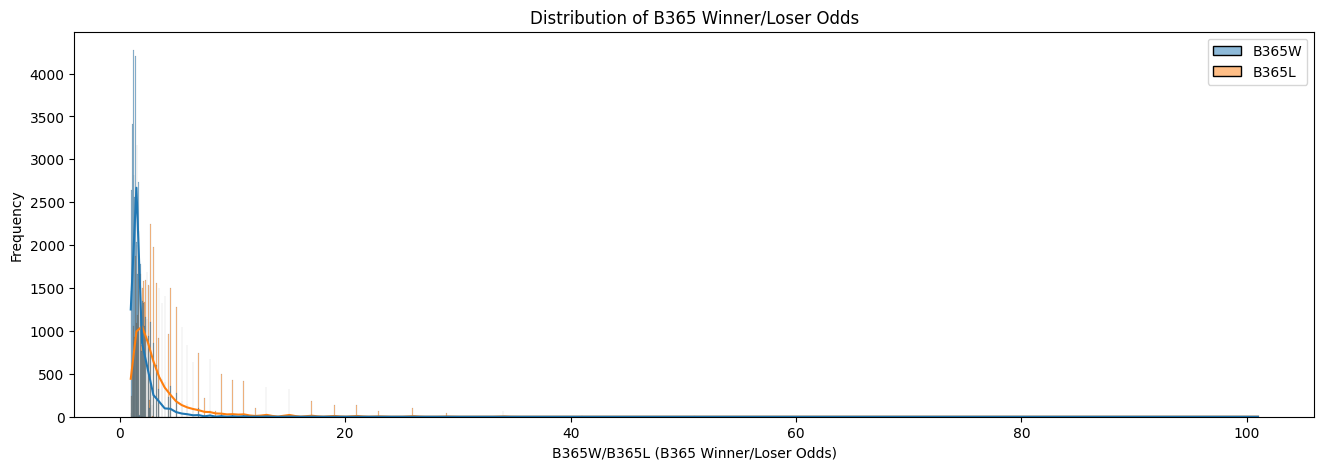

They max on 34.0 (for winners) and 101.0 (for losers).


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of B365 bets on the the winner
plt.figure(figsize=(16, 5))
plt.grid()
sns.histplot(df_atp_reduced[["B365W", "B365L"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of B365 Winner/Loser Odds')
plt.xlabel('B365W/B365L (B365 Winner/Loser Odds)')
plt.ylabel('Frequency')

# Save the plot
plt.savefig('report/final/pictures/b365-odds-dist.pdf')

# Show the plot
plt.show()
print(f"They max on {df_atp_reduced['B365W'].max()} (for winners) and {df_atp_reduced['B365L'].max()} (for losers).")

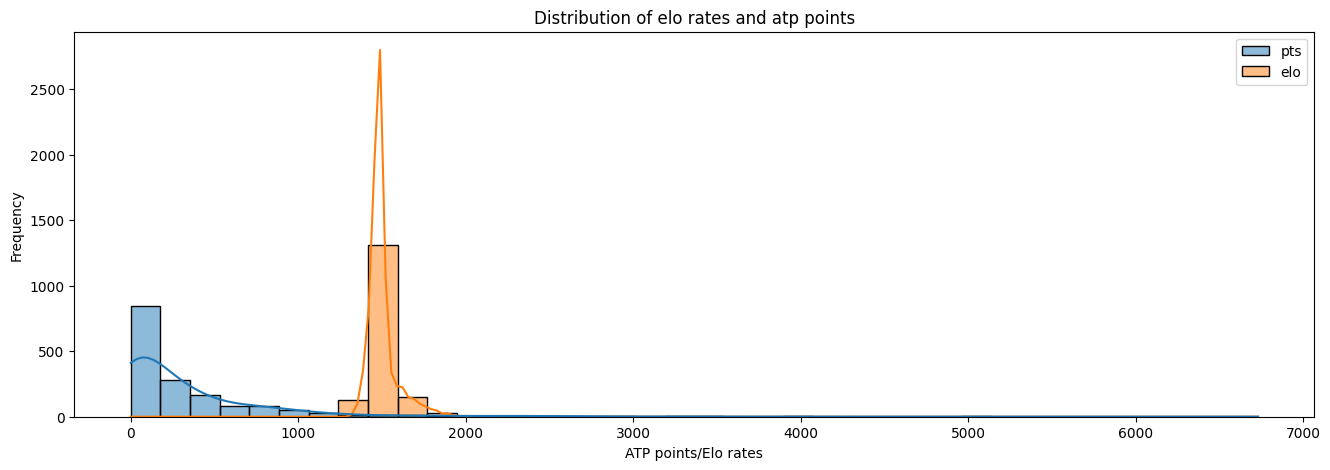

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
plt.grid()
sns.histplot(elo_rates[["pts", "elo"]], kde=True, color=[["green"], ["red"]])

# Add labels and title
plt.title('Distribution of elo rates and atp points')
plt.xlabel('ATP points/Elo rates')
plt.ylabel('Frequency')

# Save the plot
plt.savefig('report/final/pictures/elo-rates-atp-point-dist.pdf')

# Show the plot
plt.show()

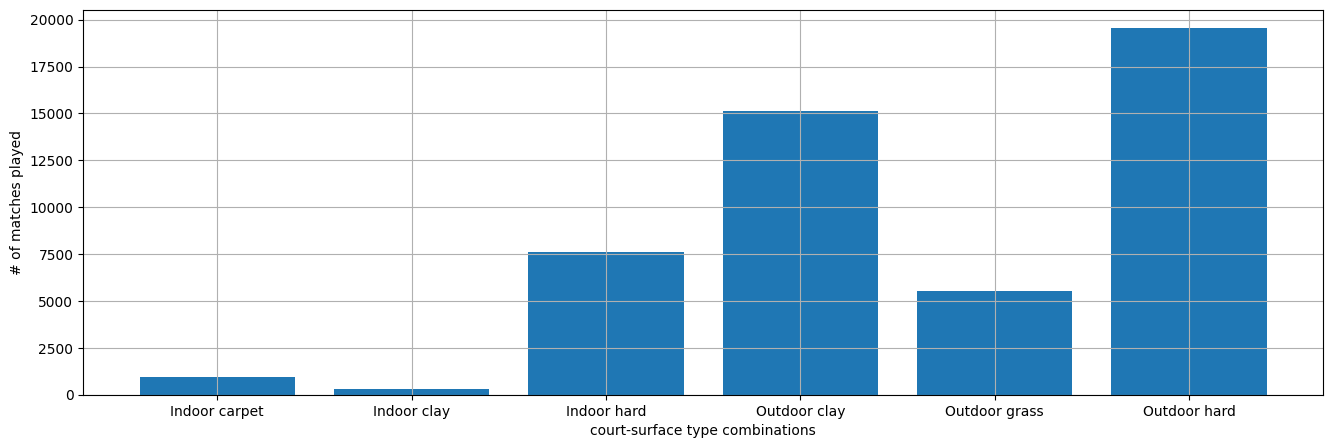

In [13]:
import matplotlib.pyplot as plt

df_fields = df_atp_reduced[["Court", "Surface", "ATP"]].groupby(by=["Court", "Surface"]).agg({"ATP": "count"}).reset_index().rename({"ATP": "match_count"}, axis=1)

plt.figure(figsize=(16, 5))
plt.grid()
plt.bar(x=df_fields["Court"] + " " + df_fields["Surface"].str.lower(), height=df_fields["match_count"])
plt.xticks(rotation=0)
plt.ylabel("# of matches played")
plt.xlabel("court-surface type combinations")

# Save the plot
plt.savefig('report/final/pictures/match-count-field-type-dist.pdf')

plt.show()

Accordingly, the total number of the matches played on the ``indoor clay`` and ``carpet`` surfaces are insignificant compared to the rest.

# Top 10 players over all (without considering the field type):

In [14]:
print(f"Top 10 players over all (without considering the field type):")
elo_rates[["Player", "match_count", "elo"]].sort_values(by="elo", ascending=False).iloc[:10]

Top 10 players over all (without considering the field type):


,Player,match_count,elo
84,Djokovic N.,1243,2023.491115
3,Federer R.,1442,1986.278216
80,Murray A.,955,1941.958733
446,Nalbandian D.,541,1927.286658
8,Hewitt L.,727,1900.514644
199,Sinner J.,266,1893.842281
204,Rune H.,160,1893.062024
427,Alcaraz C.,199,1888.284754
85,del Potro J.M.,587,1883.041401
127,Dimitrov G.,690,1875.416403


# Top 10 players in indoor courts and on hard surfaces:

In [15]:
court_surface_type = df_atp_reduced[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()

index = 0
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on hard surfaces:


,Player,match_count_indoor_hard,elo_indoor_hard
84,Djokovic N.,193,1945.849970
3,Federer R.,251,1883.679490
80,Murray A.,165,1866.309635
204,Rune H.,49,1805.686260
85,del Potro J.M.,115,1802.828205
446,Nalbandian D.,63,1775.770427
127,Dimitrov G.,145,1769.494252
199,Sinner J.,78,1767.537882
482,Zverev A.,104,1760.040718
98,Soderling R.,116,1741.011454


# Top 10 players in indoor courts and on carpet surfaces:

In [16]:
index = 1
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on carpet surfaces:


,Player,match_count_indoor_carpet,elo_indoor_carpet
446,Nalbandian D.,45,1743.530935
448,Safin M.,64,1725.213894
3,Federer R.,60,1678.953410
370,Kafelnikov Y.,37,1669.796325
38,Davydenko N.,57,1664.012327
7,Henman T.,37,1659.057469
80,Murray A.,24,1645.667525
98,Soderling R.,29,1643.943041
233,Youzhny M.,62,1640.301804
106,Roddick A.,36,1632.421053


# Top 10 players in indoor courts and on clay surfaces:

In [17]:
index = 2
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in indoor courts and on clay surfaces:


,Player,match_count_indoor_clay,elo_indoor_clay
325,Cuevas P.,19,1625.072438
321,Jarry N.,12,1578.487585
320,Pella G.,14,1573.177593
479,Garin C.,14,1571.159831
152,Nadal R.,4,1567.504325
516,Ruud C.,10,1563.889683
181,Fognini F.,11,1563.143787
446,Nalbandian D.,8,1561.387034
736,Seyboth Wild T.,10,1554.128924
480,Delbonis F.,22,1552.233578


# Top 10 players in outdoor courts and on hard surfaces:

In [18]:
index = 3
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on hard surfaces:


,Player,match_count_outdoor_hard,elo_outdoor_hard
84,Djokovic N.,582,2150.327076
3,Federer R.,638,2065.583088
80,Murray A.,480,1939.868902
152,Nadal R.,535,1936.619138
161,Medvedev D.,222,1890.534755
541,Sampras P.,91,1875.727381
427,Alcaraz C.,84,1867.918893
85,del Potro J.M.,295,1861.633644
199,Sinner J.,104,1860.047844
535,Agassi A.,207,1853.113625


# Top 10 players in outdoor courts and on clay surfaces:

In [19]:
index = 4
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on clay surfaces:


,Player,match_count_outdoor_clay,elo_outdoor_clay
152,Nadal R.,500,2114.613427
84,Djokovic N.,327,1945.543435
80,Murray A.,151,1932.700870
427,Alcaraz C.,77,1855.614868
85,del Potro J.M.,112,1849.782458
100,Nishikori K.,151,1832.153260
3,Federer R.,280,1819.559771
318,Tsitsipas S.,123,1806.636908
98,Soderling R.,120,1806.357339
451,Kuerten G.,145,1797.097969


# Top 10 players in outdoor courts and on grass surfaces:

In [20]:
index = 5
field_type = f"{court_surface_type[index][0].lower()}_{court_surface_type[index][1].lower()}"
print(f"Top 10 players in {court_surface_type[index][0].lower()} courts and on {court_surface_type[index][1].lower()} surfaces:")
elo_rates[["Player", f"match_count_{field_type}", f"elo_{field_type}"]].sort_values(by=f"elo_{field_type}", ascending=False).iloc[:10]

Top 10 players in outdoor courts and on grass surfaces:


,Player,match_count_outdoor_grass,elo_outdoor_grass
84,Djokovic N.,128,2031.642431
3,Federer R.,213,1983.267325
152,Nadal R.,97,1843.355226
80,Murray A.,135,1829.604428
130,Cilic M.,110,1819.177954
106,Roddick A.,103,1767.299838
72,Berdych T.,98,1766.786125
139,Raonic M.,74,1754.255720
8,Hewitt L.,134,1749.842855
94,Tsonga J.W.,72,1747.980698


It's time to define some betting strategies (base line):

1. To bet on the higher ranked player (HPBS)
2. To bet on the lower ranked player (LPBS)
3. To bet on the player with higher total elo rate (HRBS)
4. To bet on the player with lower total elo rate (LRBS)
5. To bet on the player with the better elo rate in the appropirate field type (BRFTBS)
6. To bet on a random player (RPBS)
7. To bet on the winner always (WBS)
8. To bet on the loser always (LBS)

Ofcourse, the strategies 7 and 8 are just theoretical and put there to compare the strategies with the theoretical maximum profit/loss.

In [21]:
import numpy as np

profit = df_atp_reduced[["Court", "Surface", "Winner", "Loser", "WPts", "LPts", "PSW", "B365W", "proba_elo", "proba_elo_indoor_hard", "proba_elo_indoor_clay", "proba_elo_indoor_carpet", "proba_elo_outdoor_hard", "proba_elo_outdoor_clay", "proba_elo_outdoor_grass"]].copy()

# Strategy 1
strategies = pd.DataFrame(df_atp["WPts"] > df_atp["LPts"], columns=["HPBS"], index=df_atp_reduced.index)
profit[["HPBS_PS", "HPBS_B365"]] = profit.loc[strategies["HPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "HPBS_PS", "B365W": "HPBS_B365"}) - 1.0

# Strategy 2
strategies["LPBS"] = df_atp["WPts"] < df_atp["LPts"]
profit[["LPBS_PS", "LPBS_B365"]] = profit.loc[strategies["LPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LPBS_PS", "B365W": "LPBS_B365"}) - 1.0

# Strategy 3
strategies["HRBS"] = df_atp["elo_winner"] > df_atp["elo_loser"]
profit[["HRBS_PS", "HRBS_B365"]] = profit.loc[strategies["HRBS"], ["PSW", "B365W"]].rename(columns={"PSW": "HRBS_PS", "B365W": "HRBS_B365"}) - 1.0

# Strategy 4
strategies["LRBS"] = df_atp["elo_winner"] < df_atp["elo_loser"]
profit[["LRBS_PS", "LRBS_B365"]] = profit.loc[strategies["LRBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LRBS_PS", "B365W": "LRBS_B365"}) - 1.0

# Strategy 5
court_surface_type = df_atp[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()
strategies["BRFTBS"] = False
for pair in court_surface_type:
    col_name = f"proba_elo_{pair[0].lower()}_{pair[1].lower()}"
    strategies.loc[(profit["Court"]==pair[0]) & (profit["Surface"]==pair[1]), "BRFTBS"] = profit.loc[(profit["Court"]==pair[0]) & (profit["Surface"]==pair[1]), col_name] >= .5
profit[["BRFTBS_PS", "BRFTBS_B365"]] = profit.loc[strategies["BRFTBS"], ["PSW", "B365W"]].rename(columns={"PSW": "BRFTBS_PS", "B365W": "BRFTBS_B365"}) - 1.0

# Strategy 6
np.random.seed(13572)
strategies["RPBS"] = np.random.randint(0, 2, size=len(strategies))==1
profit[["RPBS_PS", "RPBS_B365"]] = profit.loc[strategies["RPBS"], ["PSW", "B365W"]].rename(columns={"PSW": "RPBS_PS", "B365W": "RPBS_B365"}) - 1.0

# Strategy 7
strategies["WBS"] = True
profit[["WBS_PS", "WBS_B365"]] = profit.loc[strategies["WBS"], ["PSW", "B365W"]].rename(columns={"PSW": "WBS_PS", "B365W": "WBS_B365"}) - 1.0

# Strategy 8
strategies["LBS"] = False
profit[["LBS_PS", "LBS_B365"]] = profit.loc[strategies["LBS"], ["PSW", "B365W"]].rename(columns={"PSW": "LBS_PS", "B365W": "LBS_B365"}) - 1.0

# profit.dropna(axis=0, subset=["PSW", "B365W"], inplace=True)
profit.fillna(value=-1.0, inplace=True)

profit.head(10)

,Court,Surface,Winner,Loser,WPts,LPts,PSW,B365W,proba_elo,proba_elo_indoor_hard,...,LRBS_PS,LRBS_B365,BRFTBS_PS,BRFTBS_B365,RPBS_PS,RPBS_B365,WBS_PS,WBS_B365,LBS_PS,LBS_B365
125,Outdoor,Hard,Dent T.,Horna L.,0.0,0.0,1.241,1.160,0.500000,0.5,...,-1.000,-1.000,0.241,0.160,0.241,0.160,0.241,0.160,-1.0,-1.0
126,Outdoor,Hard,Martin A.,Ancic M.,0.0,0.0,2.170,2.000,0.598188,0.5,...,-1.000,-1.000,1.170,1.000,1.170,1.000,1.170,1.000,-1.0,-1.0
127,Outdoor,Hard,Beck K.,Vahaly B.,0.0,0.0,1.730,1.830,0.455081,0.5,...,0.730,0.830,-1.000,-1.000,0.730,0.830,0.730,0.830,-1.0,-1.0
128,Outdoor,Hard,Nieminen J.,Moodie W.,0.0,0.0,1.459,1.400,0.500000,0.5,...,-1.000,-1.000,0.459,0.400,0.459,0.400,0.459,0.400,-1.0,-1.0
130,Outdoor,Hard,Arthurs W.,Karlovic I.,0.0,0.0,1.862,1.800,0.439260,0.5,...,0.862,0.800,-1.000,-1.000,-1.000,-1.000,0.862,0.800,-1.0,-1.0
131,Outdoor,Hard,Sanguinetti D.,Elsner D.,0.0,0.0,1.699,1.800,0.500000,0.5,...,-1.000,-1.000,0.699,0.800,0.699,0.800,0.699,0.800,-1.0,-1.0
133,Outdoor,Hard,Hrbaty D.,Benneteau J.,0.0,0.0,1.592,1.533,0.476990,0.5,...,0.592,0.533,-1.000,-1.000,0.592,0.533,0.592,0.533,-1.0,-1.0
134,Outdoor,Hard,Clement A.,Hanescu V.,0.0,0.0,1.526,1.444,0.479057,0.5,...,0.526,0.444,-1.000,-1.000,0.526,0.444,0.526,0.444,-1.0,-1.0
135,Outdoor,Hard,Llodra M.,Burgsmuller L.,0.0,0.0,1.676,1.615,0.500000,0.5,...,-1.000,-1.000,0.676,0.615,0.676,0.615,0.676,0.615,-1.0,-1.0
136,Outdoor,Hard,Saulnier C.,Ginepri R.,0.0,0.0,2.700,2.625,0.500000,0.5,...,-1.000,-1.000,1.700,1.625,-1.000,-1.000,1.700,1.625,-1.0,-1.0


# This is how each strategy would perform on "Pinnacle Sports":

In [22]:
print("The statistics related to bet strategies on \"Pinnacle Sports\"")
profit[["HPBS_PS", "LPBS_PS", "HRBS_PS", "LRBS_PS", "BRFTBS_PS", "RPBS_PS", "WBS_PS", "LBS_PS"]].describe()

The statistics related to bet strategies on "Pinnacle Sports"


,HPBS_PS,LPBS_PS,HRBS_PS,LRBS_PS,BRFTBS_PS,RPBS_PS,WBS_PS,LBS_PS
count,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.0
mean,-0.034170,-0.047894,-0.004574,-0.071679,0.006320,-0.030564,0.926528,-1.0
std,0.817617,1.680366,0.876072,1.651572,0.929184,1.346063,1.281506,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.028000,-1.0
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.280000,-1.0
50%,0.180000,-1.000000,0.180000,-1.000000,0.171000,0.010000,0.560000,-1.0
75%,0.476000,0.794000,0.500000,0.700000,0.510000,0.565000,1.150000,-1.0
max,11.000000,45.000000,14.000000,45.000000,20.000000,45.000000,45.000000,-1.0


# This is how each strategy would perform on "Bet 365":

In [23]:
print("The statistics related to bet strategies on \"Bet 365\"")
profit[["HPBS_B365", "LPBS_B365", "HRBS_B365", "LRBS_B365", "BRFTBS_B365", "RPBS_B365", "WBS_B365", "LBS_B365"]].describe()

The statistics related to bet strategies on "Bet 365"


,HPBS_B365,LPBS_B365,HRBS_B365,LRBS_B365,BRFTBS_B365,RPBS_B365,WBS_B365,LBS_B365
count,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.000000,49074.0
mean,-0.066666,-0.105147,-0.039380,-0.127194,-0.029235,-0.076004,0.836080,-1.0
std,0.832100,1.501780,0.880207,1.473254,0.923948,1.237792,1.124247,0.0
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.029000,-1.0
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.250000,-1.0
50%,0.140000,-1.000000,0.140000,-1.000000,0.140000,0.005000,0.500000,-1.0
75%,0.400000,0.720000,0.440000,0.610000,0.440000,0.500000,1.100000,-1.0
max,33.000000,28.000000,33.000000,28.000000,33.000000,33.000000,33.000000,-1.0


Summary of the strategies:
- The self-defined variable -field specific Elo rate- is suprisingly the most relevant variable among the ones we defined.
- Except strategy 5 (To bet on the player with the better elo rate in the appropriate field type (BRFTBS)), all betting strategies perform poorly.
- This low marginal profit (in case of BRFTBS on PS) can turn up negative by choosing an arbitrary sub set of the matches, which means losing money.
- Even in the best case senario, his low margin of profit is increases the risk of losing money.
- Therefore, we have to come up with new betting strategies, to gain some money.

To beat bookmakers, we used ML to predict matches as accurate as possible. Algorithms:
- Random Forest
- Decision tree with Ada boost
- Support Vector Machine
- Voting algorithm combining above-mentioned algorithms
- Neural Network

# Constructing the feature set:

In [57]:
import pandas as pd
import numpy as np
import sklearn.model_selection
import sklearn.preprocessing
import joblib

# Load from disk
df_atp_reduced = pd.read_csv("archive/df_atp_reduced.csv", index_col=0)


def extract_features(df: pd.DataFrame, shuffle_mask: np.ndarray | pd.Series | None=None) -> pd.DataFrame:
    # Let's Suffle the players in a way that there is 50% chance for the player A to win and 50% for player B.
    if shuffle_mask is None:
        np.random.seed(98245)
        shuffle_mask = np.random.randint(0, 2, size=len(df))==1
    elif isinstance(shuffle_mask, pd.Series) and len(shuffle_mask) == len(df):
        shuffle_mask = shuffle_mask.values
    elif not isinstance(shuffle_mask, np.ndarray) or len(shuffle_mask) != len(df):
        raise ValueError(f"inappropirate input type or incorrect length for shuffle_mask; a {type(shuffle_mask).__name__} passed")
        
    features = pd.DataFrame(shuffle_mask, columns=["P1==Winner"], index=df.index)

    # Assign the features of the players acordingly
    features["P1_wins_proba_elo"] = (shuffle_mask - df["proba_elo"]).abs()
    features["P1_match_count"] = pd.merge(df.loc[shuffle_mask, "match_count_winner"], df.loc[~shuffle_mask, "match_count_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features["P2_match_count"] = pd.merge(df.loc[shuffle_mask, "match_count_loser"], df.loc[~shuffle_mask, "match_count_winner"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features["P1_pts"] = pd.merge(df.loc[shuffle_mask, "WPts"], df.loc[~shuffle_mask, "LPts"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features["P2_pts"] = pd.merge(df.loc[shuffle_mask, "LPts"], df.loc[~shuffle_mask, "WPts"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
    features["Date"] = df["Date"]

    # Each cell in the dataframe features answers to the question whether the specified strategy predicts that player one wins
    # Before constructing the dataframe we should scramble the players so that sometimes player 1 wins and he loses the other times with equal probabilities.
    court_surface_type = df[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist()


    for pair in court_surface_type:
        field_type = f"{pair[0].lower()}_{pair[1].lower()}"
        features[f"field_type=={field_type}"] = (df["Court"].str.lower() + "_" + df["Surface"].str.lower() == field_type) + 0
        features[f"P1_match_count_{field_type}"] = pd.merge(df.loc[shuffle_mask, f"match_count_{field_type}_winner"], df.loc[~shuffle_mask, f"match_count_{field_type}_loser"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
        features[f"P2_match_count_{field_type}"] = pd.merge(df.loc[shuffle_mask, f"match_count_{field_type}_loser"], df.loc[~shuffle_mask, f"match_count_{field_type}_winner"], how="outer", left_index=True, right_index=True).fillna(value=0).sum(axis=1).astype("int")
        features[f"P1_wins_proba_elo_{field_type}"] = (~shuffle_mask - df[f"proba_elo_{field_type}"]).abs()

    return features

# We trow out the data related to the indoor clay and carpet matches, as the elo rates belonging to them are in imature
df_atp_reduced = df_atp_reduced[(df_atp_reduced["Court"]=="Outdoor") | (df_atp_reduced["Surface"]=="Hard")]

# Shuffle P1 & P2 according to a random mask
feature_agg = [extract_features(df=df_atp_reduced)]

# Make another feature set with the exact oposite shuffle mask
feature_agg.append(extract_features(df=df_atp_reduced, shuffle_mask=~feature_agg[0]["P1==Winner"]))

# Aggregate the two feature set
features = pd.concat(feature_agg, axis=0).sort_values(by=["Date"])

# Drop the matches in which either of the players has attended less than 10 game,
# as this is considered as too imature scores.
print(f"row count before droping imature elo rates: {len(features)}")
cutoff = 5
drop_list = ["Date", "P1_match_count", "P2_match_count"]
for pair in df_atp_reduced[["Court", "Surface"]].drop_duplicates().sort_values(by="Court").to_numpy().tolist():
    field_type = f"{pair[0].lower()}_{pair[1].lower()}"
    drop_list.append(f"P1_match_count_{field_type}")
    drop_list.append(f"P2_match_count_{field_type}")
    features = features[(features[f"P1_match_count_{field_type}"] >= cutoff) & (features[f"P2_match_count_{field_type}"] >= cutoff)]
print(f"row count after droping imature elo rates: {len(features)}")

# Drop the match count columns as their main pupose was to determine the maturity of the elo rates
features.drop(labels=drop_list, axis=1, inplace=True)
# features.drop(labels=["Date"], axis=1, inplace=True)

target = features["P1==Winner"]
data = features.drop(labels=["P1==Winner"], axis=1)

scaler = sklearn.preprocessing.StandardScaler()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index), target, test_size=0.05, shuffle=False, random_state=4362)

# Save the scaler on the disk
joblib.dump(value=scaler, filename="archive/scaler.pkl")

# Back up the different dataframes
data.to_csv("archive/data.csv")
target.to_csv("archive/target.csv")

features.tail()

row count before droping imature elo rates: 95566
row count after droping imature elo rates: 27998


,P1==Winner,P1_wins_proba_elo,P1_pts,P2_pts,field_type==indoor_hard,P1_wins_proba_elo_indoor_hard,field_type==outdoor_hard,P1_wins_proba_elo_outdoor_hard,field_type==outdoor_clay,P1_wins_proba_elo_outdoor_clay,field_type==outdoor_grass,P1_wins_proba_elo_outdoor_grass
63113,False,0.530782,7200,5490,1,0.467043,0,0.543762,0,0.300885,0,0.571744
63114,True,0.255611,11445,8455,1,0.898777,0,0.835576,0,0.626603,0,0.866195
63114,False,0.744389,8455,11445,1,0.101223,0,0.164424,0,0.373397,0,0.133805
63115,False,0.690513,5490,11445,1,0.303754,0,0.158293,0,0.191344,0,0.085269
63115,True,0.309487,11445,5490,1,0.696246,0,0.841707,0,0.808656,0,0.914731


In [35]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14042 entries, 125 to 13562
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   P1==Winner                       14042 non-null  bool   
 1   P1_wins_proba_elo                14042 non-null  float64
 2   P1_pts                           14042 non-null  int64  
 3   P2_pts                           14042 non-null  int64  
 4   field_type==indoor_hard          14042 non-null  int64  
 5   P1_wins_proba_elo_indoor_hard    14042 non-null  float64
 6   field_type==outdoor_hard         14042 non-null  int64  
 7   P1_wins_proba_elo_outdoor_hard   14042 non-null  float64
 8   field_type==outdoor_clay         14042 non-null  int64  
 9   P1_wins_proba_elo_outdoor_clay   14042 non-null  float64
 10  field_type==outdoor_grass        14042 non-null  int64  
 11  P1_wins_proba_elo_outdoor_grass  14042 non-null  float64
dtypes: bool(1), float64(5

# Random Forest Classifier:

A grid search to find the optimum hyperparameters for random forest:

In [62]:
import sklearn.ensemble
import sklearn.model_selection
import joblib

# Create and train grid model on Random Forest
grid_rf = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.RandomForestClassifier(), param_grid={"max_depth" : range(5, 20), "random_state" : range(42, 52), "max_features": ["sqrt", "log2", None], "min_samples_split": range(20, 31)}, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_rf, filename="archive/grid_rf.pkl")

grid_rf.best_params_
# output: {"max_depth": 12, "max_features": "sqrt", "min_samples_split": 27, "random_state": 47}

{'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_split': 27,
 'random_state': 47}

In [63]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import joblib

# Create and fit the model with the optimum hyperparameters
model_rfc = sklearn.ensemble.RandomForestClassifier(max_depth=12, max_features="sqrt", min_samples_split=27, random_state=47, n_jobs=-1)
model_rfc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_rfc, filename="archive/model_rfc.pkl")

rfc_result = pd.DataFrame({"rfc_result": ~np.logical_xor(model_rfc.predict(X_test), y_test), "rfc_proba_P1_wins": model_rfc.predict_proba(X_test)[:, 1]}, index=y_test.index)

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

print(f"Random forest with the given features can predict correctly with the probability of {round(model_rfc.score(X_test, y_test)*100, 2)} %")
profits_test[["rfc_result", "rfc_certainty", "rfc_profit_PS", "rfc_profit_B365"]] = pd.DataFrame({"rfc_result": 0 + rfc_result["rfc_result"], "rfc_certainty": 2*(rfc_result["rfc_proba_P1_wins"] - .5).abs(), "rfc_profit_PS": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "rfc_profit_B365": rfc_result["rfc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Random forest with the given features can predict correctly with the probability of 65.0 %


# Decision Tree Classifier with Ada Boost:

A grid search to find the optimum hyperparameters for Ada boost (on decision tree):

In [39]:
import sklearn.model_selection
import sklearn.ensemble
import numpy as np
import joblib

# Create and train grid model on Ada boost (on decision tree)
grid_dtc_abc = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.AdaBoostClassifier(), param_grid={"estimator": [sklearn.tree.DecisionTreeClassifier(criterion="entropy", max_depth=3), sklearn.tree.DecisionTreeClassifier(criterion="gini", max_depth=3)], "learning_rate": np.power(10.0, np.arange(-3, 0, .5)), "n_estimators": range(100, 1001, 100), "algorithm": ["SAMME"], "random_state": [26645]}, n_jobs=-1)
grid_dtc_abc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_dtc_abc, filename="archive/grid_dtc_abc.pkl")

grid_dtc_abc.best_params_
# output: {'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.03162277660168379, 'n_estimators': 600, 'random_state': 26645}

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import sklearn.tree
import sklearn.ensemble
import joblib

# Create and fit the model with the optimum hyperparameters
model_dtc = sklearn.tree.DecisionTreeClassifier(max_depth=3)
model_dtc_abc = sklearn.ensemble.AdaBoostClassifier(estimator=model_dtc, learning_rate=3.162277660168379e-2, n_estimators=600, algorithm="SAMME", random_state=26645)
model_dtc_abc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_dtc_abc, filename="archive/model_dtc_abc.pkl")

dtc_abc_result = pd.DataFrame({"dtc_abc_result": ~np.logical_xor(model_dtc_abc.predict(X_test), y_test), "dtc_abc_proba_P1_wins": model_dtc_abc.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of {round(model_dtc_abc.score(X_test, y_test)*100, 2)} %")

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test[["dtc_abc_result", "dtc_abc_certainty", "dtc_abc_profit_PS", "dtc_abc_profit_B365"]] = pd.DataFrame({"dtc_abc_result": 0 + dtc_abc_result["dtc_abc_result"], "dtc_abc_certainty": 2*(dtc_abc_result["dtc_abc_proba_P1_wins"] - .5).abs(), "dtc_abc_profit_PS": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "dtc_abc_profit_B365": dtc_abc_result["dtc_abc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Decision tree with Ada boost algorithm with the given features can predict correctly with the probability of 70.69 %


# Support Vector Classifier:

A grid search to find the optimum hyperparameters for svm:

In [ ]:
import sklearn.svm
import sklearn.model_selection
import joblib

# Create and train grid model on svm
grid_svm = sklearn.model_selection.GridSearchCV(estimator=sklearn.svm.SVC(), param_grid={"kernel" : ["rbf", "linear", "poly", "sigmoid"], "C" : [.1, 1.0, 10.0, 50.0], "random_state": [9274]}, n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=grid_svm, filename="archive/grid_svm.pkl")

grid_svm.best_params_
# output: {"C": 1.0, "kernel": "rbf", "random_state": 9274}

{'C': 1.0, 'kernel': 'rbf', 'random_state': 9274}

In [ ]:
import pandas as pd
import numpy as np
import sklearn.svm
import joblib

# Create and fit the model with the optimum hyperparameters
model_svm = sklearn.svm.SVC(kernel="rbf", C=1.0, probability=True, random_state=9274)
model_svm.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_svm, filename="archive/model_svm.pkl")

svm_result = pd.DataFrame({"svm_result": ~np.logical_xor(model_svm.predict(X_test), y_test), "svm_proba_P1_wins": model_svm.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"SVM with the given features can predict correctly with the probability of {round(model_svm.score(X_test, y_test)*100, 2)} %")

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test[["svm_result", "svm_certainty", "svm_profit_PS", "svm_profit_B365"]] = pd.DataFrame({"svm_result": 0 + svm_result["svm_result"], "svm_certainty": 2*(svm_result["svm_proba_P1_wins"] - .5).abs(), "svm_profit_PS": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "svm_profit_B365": svm_result["svm_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

SVM with the given features can predict correctly with the probability of 69.89 %


In [ ]:
import sklearn.ensemble
import joblib
import pandas as pd

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

accuracies = profits_test[["rfc_result", "dtc_abc_result", "svm_result"]].mean(axis=0).to_numpy()

# Create and fit the voting model
model_vc = sklearn.ensemble.VotingClassifier(estimators=[("rfc", model_rfc), ("dtc_abc", model_dtc_abc), ("svc", model_svm)], weights=accuracies, voting="soft", n_jobs=-1)
model_vc.fit(X_train, y_train)

# Save the model to disk
joblib.dump(value=model_vc, filename="archive/model_vc.pkl")

vc_result = pd.DataFrame({"vc_result": ~np.logical_xor(model_vc.predict(X_test), y_test), "vc_proba_P1_wins": model_vc.predict_proba(X_test)[:, 1]}, index=y_test.index)
print(f"Voting classifier with the given features can predict correctly with the probability of {round(model_vc.score(X_test, y_test)*100, 2)} %")

profits_test[["vc_result", "vc_certainty", "vc_profit_PS", "vc_profit_B365"]] = pd.DataFrame({"vc_result": 0 + vc_result["vc_result"], "vc_certainty": 2*(vc_result["vc_proba_P1_wins"] - .5).abs(), "vc_profit_PS": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "vc_profit_B365": vc_result["vc_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Voting classifier with the given features can predict correctly with the probability of 71.43 %


# Neural Network Classifier:

In [ ]:
import tensorflow as tf

# Define the model
model_nn = tf.keras.models.Sequential()

# Add layers to the model
model_nn.add(tf.keras.layers.Dense(40, input_dim=29, activation='relu'))    # Input layer with 29 features
# model_nn.add(tf.keras.layers.Dropout(rate=.2))                              # Dropout layer
model_nn.add(tf.keras.layers.Dense(25, activation='sigmoid'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(10, activation='sigmoid'))               # Hidden layer
model_nn.add(tf.keras.layers.Dense(5, activation='sigmoid'))                # Hidden layer
model_nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))                # Output layer with sigmoid activation for binary classification

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
# model_nn.summary()

# Fit the model
history = model_nn.fit(X_train, y_train + 0.0, epochs=60, batch_size=4096, validation_data=(X_test, y_test))

# Save the model on disk
model_nn.save("archive/model_nn.keras")

nn_result = pd.DataFrame({"nn_result": ~np.logical_xor(model_nn.predict(X_test)[:, 0]>.5, y_test), "nn_proba_P1_wins": model_nn.predict(X_test)[:, 0]}, index=y_test.index)
print(f"Neural network algorithm with the given features can predict correctly with the probability of {round(model_nn.evaluate(X_test, y_test)[1]*100, 2)} %")

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test[["nn_result", "nn_certainty", "nn_profit_PS", "nn_profit_B365"]] = pd.DataFrame({"nn_result": 0 + nn_result["nn_result"], "nn_certainty": 2*(nn_result["nn_proba_P1_wins"] - .5).abs(), "nn_profit_PS": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "PSW"].to_numpy() - 1.0, "nn_profit_B365": nn_result["nn_result"].to_numpy() * df_atp_reduced.loc[y_test.index, "B365W"].to_numpy() - 1.0}, index=y_test.index)

# Save the result on disk
profits_test.to_csv("archive/profits_test.csv")

Epoch 1/60
10/10 [==============================] - 2s 37ms/step - loss: 0.7094 - accuracy: 0.4992 - val_loss: 0.7053 - val_accuracy: 0.4973
Epoch 2/60
10/10 [==============================] - 0s 11ms/step - loss: 0.7017 - accuracy: 0.4992 - val_loss: 0.6987 - val_accuracy: 0.4973
Epoch 3/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6962 - accuracy: 0.4992 - val_loss: 0.6941 - val_accuracy: 0.4973
Epoch 4/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.4992 - val_loss: 0.6908 - val_accuracy: 0.4973
Epoch 5/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6894 - accuracy: 0.5030 - val_loss: 0.6883 - val_accuracy: 0.5292
Epoch 6/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6869 - accuracy: 0.5866 - val_loss: 0.6857 - val_accuracy: 0.6320
Epoch 7/60
10/10 [==============================] - 0s 10ms/step - loss: 0.6842 - accuracy: 0.6471 - val_loss: 0.6829 - val_accuracy: 0.6394
Epoch 8/60
10

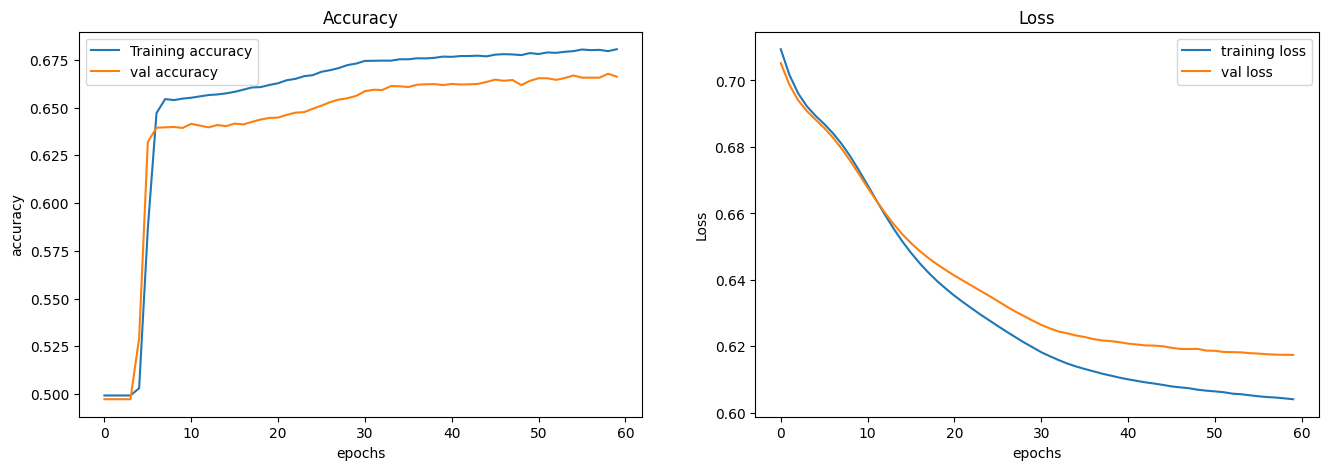

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

profits_test.describe()

,rfc_result,rfc_certainty,rfc_profit_PS,rfc_profit_B365,dtc_abc_result,dtc_abc_certainty,dtc_abc_profit_PS,dtc_abc_profit_B365,svm_result,svm_certainty,svm_profit_PS,svm_profit_B365,vc_result,vc_certainty,vc_profit_PS,vc_profit_B365,nn_result,nn_certainty,nn_profit_PS,nn_profit_B365
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,9765.000000,9765.000000,9765.000000,9765.000000,9765.000000,9765.000000,9765.000000,9765.000000
mean,0.684375,0.402196,-0.053834,-0.079191,0.687500,0.407073,-0.048119,-0.073619,0.678125,0.335747,-0.036716,-0.061003,0.655914,0.325121,-0.023245,-0.055164,0.666155,0.345596,-0.004733,-0.037282
std,0.465492,0.208228,0.705250,0.689949,0.464238,0.190772,0.704962,0.689728,0.467927,0.166999,0.741617,0.728808,0.475094,0.190894,0.794893,0.812876,0.471609,0.167254,0.797016,0.814176
min,0.000000,0.013370,-1.000000,-1.000000,0.000000,0.005740,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000158,-1.000000,-1.000000,0.000000,0.000195,-1.000000,-1.000000
25%,0.000000,0.244388,-1.000000,-1.000000,0.000000,0.269493,-1.000000,-1.000000,0.000000,0.215560,-1.000000,-1.000000,0.000000,0.161198,-1.000000,-1.000000,0.000000,0.211813,-1.000000,-1.000000
50%,1.000000,0.387925,0.172000,0.140000,1.000000,0.416677,0.177000,0.140000,1.000000,0.369234,0.180000,0.160000,1.000000,0.325228,0.190000,0.160000,1.000000,0.380881,0.200000,0.160000
75%,1.000000,0.558972,0.372500,0.330000,1.000000,0.558277,0.380000,0.330750,1.000000,0.461156,0.401250,0.360000,1.000000,0.477421,0.470000,0.400000,1.000000,0.496030,0.480000,0.440000
max,1.000000,0.947477,2.980000,3.330000,1.000000,0.761594,2.980000,3.330000,1.000000,0.697765,2.980000,3.330000,1.000000,0.777872,6.740000,28.000000,1.000000,0.573282,6.740000,28.000000


In [ ]:
import numpy as np

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

thresholds = np.arange(0.0, .7, .01)
algorithm_list = [("rfc", "random forest"), ("dtc_abc", "decision tree with Ada boost"), ("svm", "support vector machine"), ("vc", "voting"), ("nn", "neural network")]
for alg in algorithm_list:
    thresh_list = []
    profit_rates_PS = []
    profit_rates_B365 = []
    accuracies = []
    for thresh in thresholds:
        weights = 0.0 + (profits_test[f"{alg[0]}_certainty"] >= thresh)
        if weights.mean() > .1:
            thresh_list.append(thresh)
            profit_rates_PS.append(np.average(profits_test[f"{alg[0]}_profit_PS"], weights=weights))
            profit_rates_B365.append(np.average(profits_test[f"{alg[0]}_profit_B365"], weights=weights))
            accuracies.append(np.average(profits_test[f"{alg[0]}_result"], weights=weights))
    # print(len(thresh_list))
    print(f"The best PS performance for {alg[1]} algorithm occurs on the threshold value of {thresh_list[np.array(profit_rates_PS).argmax()]}, with the average profit of {profit_rates_PS[np.array(profit_rates_PS).argmax()]} (on PS) and accuracy of {accuracies[np.array(profit_rates_PS).argmax()]}")

The best PS performance for random forest algorithm occurs on the threshold value of 0.62, with the average profit of 0.007186113789778187 (on PS) and accuracy of 0.8881388621022179
The best PS performance for decision tree with Ada boost algorithm occurs on the threshold value of 0.52, with the average profit of 0.0026851453175457283 (on PS) and accuracy of 0.8460710441334769
The best PS performance for support vector machine algorithm occurs on the threshold value of 0.55, with the average profit of -0.002972196478220593 (on PS) and accuracy of 0.7970342910101946
The best PS performance for voting algorithm occurs on the threshold value of 0.5, with the average profit of -0.0016115859449192986 (on PS) and accuracy of 0.8399810066476733
The best PS performance for neural network algorithm occurs on the threshold value of 0.02, with the average profit of -0.0022838743455497507 (on PS) and accuracy of 0.6703664921465968


In [ ]:
import numpy as np

# Load profits_test from disk
profits_test = pd.read_csv("archive/profits_test.csv", index_col=0)

thresholds = np.arange(0.0, .7, .01)
algorithm_list = [("rfc", "random forest"), ("dtc_abc", "decision tree with Ada boost"), ("svm", "support vector machine"), ("vc", "voting"), ("nn", "neural network")]
for alg in algorithm_list:
    thresh_list = []
    profit_rates_PS = []
    profit_rates_B365 = []
    accuracies = []
    for thresh in thresholds:
        weights = 0.0 + (profits_test[f"{alg[0]}_certainty"] >= thresh)
        if weights.mean() > .1:
            thresh_list.append(thresh)
            profit_rates_PS.append(np.average(profits_test[f"{alg[0]}_profit_PS"], weights=weights))
            profit_rates_B365.append(np.average(profits_test[f"{alg[0]}_profit_B365"], weights=weights))
            accuracies.append(np.average(profits_test[f"{alg[0]}_result"], weights=weights))
    # print(len(thresh_list))
    print(f"The best B365 performance for {alg[1]} algorithm occurs on the threshold value of {thresh_list[np.array(profit_rates_B365).argmax()]}, with the average profit of {profit_rates_B365[np.array(profit_rates_B365).argmax()]} (on B365) and accuracy of {accuracies[np.array(profit_rates_B365).argmax()]}")

The best B365 performance for random forest algorithm occurs on the threshold value of 0.62, with the average profit of 0.011988428158148497 (on B365) and accuracy of 0.8881388621022179
The best B365 performance for decision tree with Ada boost algorithm occurs on the threshold value of 0.6, with the average profit of -0.0008690702087286582 (on B365) and accuracy of 0.8738140417457305
The best B365 performance for support vector machine algorithm occurs on the threshold value of 0.47000000000000003, with the average profit of -0.02560813915326551 (on B365) and accuracy of 0.7765014768624877
The best B365 performance for voting algorithm occurs on the threshold value of 0.58, with the average profit of -0.0001597289448209229 (on B365) and accuracy of 0.8780251694094869
The best B365 performance for neural network algorithm occurs on the threshold value of 0.51, with the average profit of -0.014405896805896816 (on B365) and accuracy of 0.830958230958231


In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load svm model from disk
model_svm = joblib.load(filename="archive/model_svm.pkl")

# Load random forest model from disk
model_rfc = joblib.load(filename="archive/model_rfc.pkl")

def get_advise(input: dict | pd.DataFrame, platform: str = "PS") -> pd.DataFrame:

    if isinstance(input, dict):
        input = pd.DataFrame(input)

    features_list = [
    "P1_wins_proba_elo",
    "P1_match_count",
    "P2_match_count",
    "P1_pts",
    "P2_pts",
    "field_type==indoor_hard",
    "P1_match_count_indoor_hard",
    "P2_match_count_indoor_hard",
    "P1_wins_proba_elo_indoor_hard",
    "field_type==indoor_carpet",
    "P1_match_count_indoor_carpet",
    "P2_match_count_indoor_carpet",
    "P1_wins_proba_elo_indoor_carpet",
    "field_type==indoor_clay",
    "P1_match_count_indoor_clay",
    "P2_match_count_indoor_clay",
    "P1_wins_proba_elo_indoor_clay",
    "field_type==outdoor_hard",
    "P1_match_count_outdoor_hard",
    "P2_match_count_outdoor_hard",
    "P1_wins_proba_elo_outdoor_hard",
    "field_type==outdoor_clay",
    "P1_match_count_outdoor_clay",
    "P2_match_count_outdoor_clay",
    "P1_wins_proba_elo_outdoor_clay",
    "field_type==outdoor_grass",
    "P1_match_count_outdoor_grass",
    "P2_match_count_outdoor_grass",
    "P1_wins_proba_elo_outdoor_grass",
]

    if set(features_list) - set(input.columns.tolist()):
        raise ValueError(f"wrong input format")

    X = input[features_list]

    if platform == "PS":
        df_result = pd.DataFrame(
            {
                "predict_P1_wins": model_rfc.predict(X),
                "certainty": np.absolute(2 * model_rfc.predict_proba(X)[:, 1] - 1.0),
            },
            index=X.index,
        )
        df_result["advise"] = df_result["predict_P1_wins"].replace(
            {True: "P1", False: "P2"}
        )
        df_result.loc[df_result["certainty"] < 0.62, "advise"] = np.nan
        return df_result[["advise", "predict_P1_wins", "certainty"]]
    elif platform == "B365":
        df_result = pd.DataFrame(
            {
                "predic_P1_wins": model_rfc.predict(X),
                "certainty": np.absolute(2 * model_rfc.predict_proba(X)[:, 1] - 1.0),
            },
            index=X.index,
        )
        df_result["advise"] = df_result["predict_P1_wins"].replace(
            {True: "P1", False: "P2"}
        )
        df_result.loc[df_result["certainty"] < 0.62, "advise"] = np.nan
        return df_result[["advise", "predict_P1_wins", "certainty"]]
    else:
        raise ValueError(f'Unkown platform "{platform}"')

    
advise_test = get_advise(X_test)

In [ ]:
print(f"This function advises to bet on {round(100.0*(1.0 - advise_test['advise'].isna().sum()/len(advise_test)), 2)} % of matches")
advise_test.head()

This function advises to bet on 10.62 % of matches


,advise,predict_P1_wins,certainty
39027,NaN,True,0.098956
33420,NaN,False,0.112164
20791,NaN,True,0.343149
56609,NaN,True,0.173465
4966,NaN,False,0.380741
